# 概要
BERTモデルは[BERT: 言語理解のための双方向Transformerの事前学習](https://arxiv.org/abs/1810.04805)で提案されました。「Bidirectional Encoder Representation with Transformers」の略です。簡単に言えば、BERTはエンコーダーを通してデータまたは単語埋め込みからパターンや表現を抽出します。エンコーダー自体は積み重ねられたトランスフォーマーアーキテクチャです。これは双方向トランスフォーマーで、トレーニング中に語彙の左右両方のコンテキストを考慮してパターンや表現を抽出します。
![](https://huggingface.co/blog/assets/52_bert_101/BERT-size-and-architecture.png)

In [2]:
import torch
print(torch.__version__)
import transformers
print(transformers.__version__)
import numpy as np
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

2.3.0
4.40.2


/opt/miniconda3/envs/nlp/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
model = BertModel.from_pretrained('bert-base-uncased')
model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.40.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

# BERT-baseアーキテクチャのパラメータ説明

## 1. 主要なアーキテクチャコンポーネント
### トランスフォーマー層 (`num_hidden_layers: 12`)
- BERT-baseは12のトランスフォーマーエンコーダー層を持つ
- 各層は以下を含む:
  * マルチヘッド自己注意機構
  * フィードフォワードニューラルネットワーク
  * レイヤー正規化
  * 残差接続

### 注意機構
- `num_attention_heads: 12`
  * 各層は12の注意ヘッドを持つ
  * 各ヘッドは入力の異なる部分を処理
- `hidden_size: 768`
  * 隠れ状態の次元
  * 各注意ヘッドは64次元のデータを処理 (768/12 = 64)

### フィードフォワードネットワーク
- `intermediate_size: 3072`
  * フィードフォワードネットワークの中間層のサイズ
  * 隠れサイズの4倍 (768 * 4 = 3072)
  * シーケンス: 768 → 3072 → 768 (GELU活性化関数使用)

## 2. その他の重要なパラメータ
### 埋め込みとシーケンス
- `vocab_size: 30522`
  * トークナイザーの語彙サイズ
- `max_position_embeddings: 512`
  * モデルが処理できる最大シーケンス長
- `type_vocab_size: 2`
  * セグメント埋め込み用（文A/B）

### モデル設定
- `hidden_act: "gelu"`
  * 使用される活性化関数
- `layer_norm_eps: 1e-12`
  * 数値の安定性のための小さな定数
- `attention_probs_dropout_prob: 0.1`
  * アテンション確率のドロップアウト率
- `hidden_dropout_prob: 0.1`
  * 全結合層のドロップアウト率

### 位置情報
- `position_embedding_type: "absolute"`
  * 絶対位置埋め込みを使用

# BERT Embeddings
BERTはテキストを数値ベクトルとして表現することができる。

In [4]:
# 事前学習済みBERTモデルとトークナイザーの読み込み
model = BertModel.from_pretrained('bert-base-uncased')

# 入力テキスト
sentence = "BERT is a transformer-based model for NLP tasks."

# 入力のエンコード
inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)

# 隠れ状態の取得
with torch.no_grad():
    outputs = model(**inputs)
    # 最終層の隠れ状態 (バッチサイズ, シーケンス長, 隠れ層の次元)
    hidden_states = outputs.last_hidden_state

# [CLS]トークンの表現を文埋め込みとして取得
sentence_embedding = hidden_states[:, 0, :]  # [CLS]埋め込み
print(sentence_embedding.shape)  # 出力: torch.Size([1, 768])

torch.Size([1, 768])


In [5]:
sentences = [
   # 自然言語処理関連の文章
   "Deep learning models have transformed natural language processing.",  # S2/S3のような技術的な文章
   "Transformers have revolutionized NLP tasks.",
   "Natural language processing is advancing rapidly.",
   
   # 天気関連の文章
   "The weather is sunny and warm today.",
   "It might rain this afternoon.",
   "The temperature will drop tomorrow.",
   
   # スポーツ関連の文章
   "The basketball team won the championship.",
   "The NBA finals were incredibly exciting.",  # S7のようなバスケットボール専門の文章
   "The Lakers dominated the basketball season."  # S7のようなバスケットボール専門の文章
]

# すべての文章の埋め込みを取得
embeddings = []
with torch.no_grad():
   for sentence in sentences:
       inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
       outputs = model(**inputs).last_hidden_state
       embeddings.append(outputs[:, 0, :])  # [CLS]トークンの埋め込みを取得

# NumPy配列に変換して結合
embeddings_np = np.vstack([emb.numpy() for emb in embeddings])
print(embeddings_np.shape)  # 出力: (9, 768)

(9, 768)


/var/folders/v0/5gx8ss_j2t55l30n8jm5d2t40000gn/T/ipykernel_3395/2289372731.py:36: UserWarning: Glyph 25991 (\N{CJK UNIFIED IDEOGRAPH-6587}) missing from current font.
  plt.tight_layout()
/var/folders/v0/5gx8ss_j2t55l30n8jm5d2t40000gn/T/ipykernel_3395/2289372731.py:36: UserWarning: Glyph 31456 (\N{CJK UNIFIED IDEOGRAPH-7AE0}) missing from current font.
  plt.tight_layout()
/var/folders/v0/5gx8ss_j2t55l30n8jm5d2t40000gn/T/ipykernel_3395/2289372731.py:36: UserWarning: Glyph 22475 (\N{CJK UNIFIED IDEOGRAPH-57CB}) missing from current font.
  plt.tight_layout()
/var/folders/v0/5gx8ss_j2t55l30n8jm5d2t40000gn/T/ipykernel_3395/2289372731.py:36: UserWarning: Glyph 12417 (\N{HIRAGANA LETTER ME}) missing from current font.
  plt.tight_layout()
/var/folders/v0/5gx8ss_j2t55l30n8jm5d2t40000gn/T/ipykernel_3395/2289372731.py:36: UserWarning: Glyph 36796 (\N{CJK UNIFIED IDEOGRAPH-8FBC}) missing from current font.
  plt.tight_layout()
/var/folders/v0/5gx8ss_j2t55l30n8jm5d2t40000gn/T/ipykernel_3395/2289

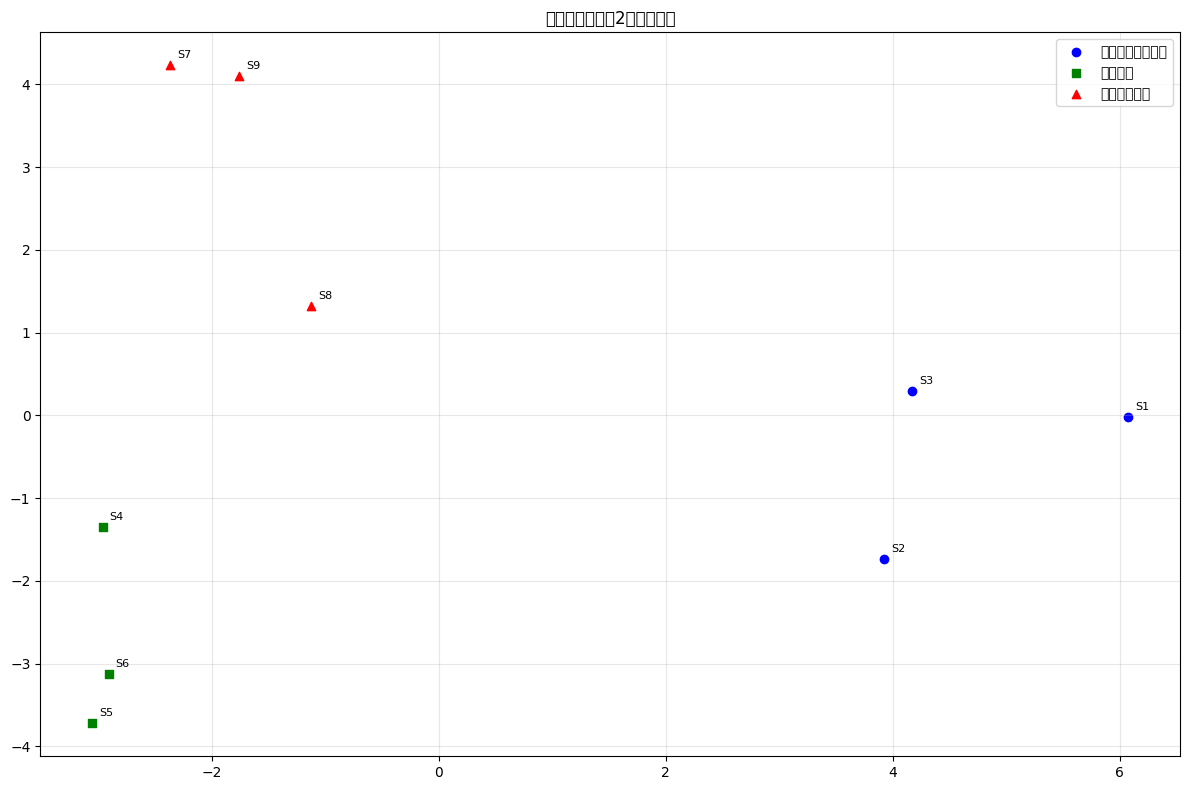

In [6]:
# PCAによる次元削減を適用（768次元から2次元へ）
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_np)

# グループごとに異なる色を使用して散布図を作成
plt.figure(figsize=(12, 8))

# グループごとに異なる色とマーカーでプロット
colors = ['blue', 'green', 'red']  # 各グループの色を定義
markers = ['o', 's', '^']  # マーカーの形状を定義: 丸、四角、三角

for i in range(3):  # 3つのグループをループ
   start_idx = i * 3
   end_idx = start_idx + 3
   plt.scatter(embeddings_2d[start_idx:end_idx, 0], 
              embeddings_2d[start_idx:end_idx, 1], 
              c=colors[i], 
              marker=markers[i],
              label=f'グループ {i+1}')

# 各点にラベルを追加
# S1, S2などの形式で文章番号を表示
for idx, sentence in enumerate(sentences):
   plt.annotate(f"S{idx+1}", 
               (embeddings_2d[idx, 0], embeddings_2d[idx, 1]),
               xytext=(5, 5), 
               textcoords='offset points',
               fontsize=8)

# プロットのカスタマイズ
plt.title("文章埋め込みの2次元可視化")  # タイトルの設定
plt.legend(['自然言語処理関連', '天気関連', 'スポーツ関連'])  # 凡例の設定
plt.grid(True, alpha=0.3)  # グリッドの表示（透明度0.3）

# レイアウトの調整
plt.tight_layout()

# プロットの表示
plt.show()

# Masked Token Prediction
BERTはマスクされたトークンを予測することができる。

In [7]:
from transformers import BertForMaskedLM

# 事前学習済みのマスク言語モデルを読み込む
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
model.eval()  # 評価モードに設定

# [MASK]トークンを含む入力テキストを準備
text = "The [MASK] is shining brightly in the sky."  # 「空で明るく輝いている[MASK]」

# テキストをエンコード
inputs = tokenizer(text, return_tensors="pt")

# [MASK]トークンの位置を取得
mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]

# 予測を実行
with torch.no_grad():
   outputs = model(**inputs)
   predictions = outputs.logits  # 予測結果（ロジット）を取得

# 最も確率の高いトークンを取得
predicted_token_id = predictions[0, mask_token_index].argmax(axis=-1)
predicted_token = tokenizer.decode(predicted_token_id)

print(f"入力テキスト: {text}")
print(f"BERTが予測した[MASK]の単語: {predicted_token}")

# 上位5つの予測結果を表示
# softmax関数で確率に変換
probs = torch.nn.functional.softmax(predictions[0, mask_token_index], dim=-1)
# 確率が高い順に上位5つを取得
top_5_tokens = torch.topk(probs, 5, dim=-1)

print("\n上位5つの予測結果:")
for token, prob in zip(top_5_tokens.indices[0], top_5_tokens.values[0]):
   word = tokenizer.decode([token])
   print(f"{word}: {prob:.3f}")  # 単語と確率を表示

/opt/miniconda3/envs/nlp/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


入力テキスト: The [MASK] is shining brightly in the sky.
BERTが予測した[MASK]の単語: sun

上位5つの予測結果:
sun: 0.605
moon: 0.359
sunset: 0.006
star: 0.004
city: 0.002


# Next Sentence Prediction
BERTは2つの文間の関係性を判定することができます。

In [8]:
from transformers import BertForNextSentencePrediction
# 事前学習済みのモデルを読み込む
model = BertForNextSentencePrediction.from_pretrained('bert-base-uncased')
model.eval()

# 文章ペアの例を準備
sentence_pairs = [
   ["The restaurant is famous.", "Jupiter is the largest planet."],  # 無関係な文章ペア
   ["The weather is very cold.", "There is snow everywhere."],     # 関連のある文章ペア
]

# 各文章ペアをテスト
for sentences in sentence_pairs:
   # 文章ペアをエンコード
   encoding = tokenizer(sentences[0], sentences[1], return_tensors='pt', padding=True)
   
   # 予測を実行
   with torch.no_grad():
       outputs = model(**encoding)
       predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
   
   # 予測確率を取得
   is_next_prob = predictions[0][0].item()
   
   print(f"\n文章1: {sentences[0]}")
   print(f"文章2: {sentences[1]}")
   print(f"文章が関連している確率: {is_next_prob:.3f}")
   print(f"文章が関連していない確率: {1-is_next_prob:.3f}")


文章1: The restaurant is famous.
文章2: Jupiter is the largest planet.
文章が関連している確率: 0.000
文章が関連していない確率: 1.000

文章1: The weather is very cold.
文章2: There is snow everywhere.
文章が関連している確率: 1.000
文章が関連していない確率: 0.000


In [ ]:
torch.mps.empty_cache() # メモリ解放, macos
torch.cuda.empty_cache() # メモリ解放, CUDA

# NER (Named Entity Recognition)
BERTは文の中の固有名詞を識別することができる。
![](https://miro.medium.com/v2/resize:fit:937/0*gDVxdYislF3CJVjq.png)

In [13]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

nlp = pipeline("ner", model=model, tokenizer=tokenizer)
example = "My name is Wolfgang and I live in Berlin"

ner_results = nlp(example)
print(ner_results)


Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'entity': 'B-PER', 'score': 0.9990139, 'index': 4, 'word': 'Wolfgang', 'start': 11, 'end': 19}, {'entity': 'B-LOC', 'score': 0.999645, 'index': 9, 'word': 'Berlin', 'start': 34, 'end': 40}]


# BERT Classification
BERTは文を分類することができる。

In [15]:
from transformers import BertTokenizer, BertForSequenceClassification

def classify_text(text, model, tokenizer):
    # テキストをエンコード
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt")
    
    # 予測を実行
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    
    return predictions.numpy()


# 事前学習済みモデルとトークナイザーを読み込み
model_name = "textattack/bert-base-uncased-imdb"  # IMDBレビュー用のBERT
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# テストテキストを準備
texts = [
    "This movie was terrible, I was so bored",
    "The restaurant served amazing food with great service",
    "The product quality is poor and it broke quickly",
]

# 各テキストを分類
print("\nテキスト分類結果:")
for text in texts:
    predictions = classify_text(text, model, tokenizer)
    
    print(f"\nテキスト: {text}")
    print(f"ネガティブ確率: {predictions[0][0]:.3f}")
    print(f"ポジティブ確率: {predictions[0][1]:.3f}")
    print(f"予測結果: {'ポジティブ' if predictions[0][1] > predictions[0][0] else 'ネガティブ'}")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/511 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]


テキスト分類結果:

テキスト: This movie was terrible, I was so bored
ネガティブ確率: 0.999
ポジティブ確率: 0.001
予測結果: ネガティブ

テキスト: The restaurant served amazing food with great service
ネガティブ確率: 0.003
ポジティブ確率: 0.997
予測結果: ポジティブ

テキスト: The product quality is poor and it broke quickly
ネガティブ確率: 0.994
ポジティブ確率: 0.006
予測結果: ネガティブ
